In [515]:
import meshio
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import FaceToEdge
import matplotlib.pyplot as plt

In [516]:
class TetraToEdge(object):
    r"""Converts mesh tetras :obj:`[4, num_tetras]` to edge indices
    :obj:`[2, num_edges]`.
    Args:
        remove_tetras (bool, optional): If set to :obj:`False`, the tetra tensor
            will not be removed.
    """

    def __init__(self, remove_tetras=True):
        self.remove_tetras = remove_tetras

    def __call__(self, data):
        if data.tetra is not None:
            tetra = data.tetra
            edge_index = torch.cat([tetra[:2], tetra[1:3, :], tetra[-2:], tetra[::2], tetra[::3], tetra[1::2]], dim=1)
            edge_index = to_undirected(edge_index, num_nodes=data.num_nodes)

            data.edge_index = edge_index
            if self.remove_tetras:
                data.tetra = None

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [517]:
def from_meshio(mesh, mesh_type='2D'):
    r"""Converts a :.msh file to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        mesh (meshio.read): A :obj:`meshio` mesh.
    """

    if meshio is None:
        raise ImportError('Package `meshio` could not be found.')

    pos = torch.from_numpy(mesh.points).to(torch.float)
    if mesh_type == '3D':
        tetra = torch.from_numpy(mesh.cells_dict['tetra']).to(torch.long).t().contiguous()
        return Data(pos=pos, tetra=tetra)
    elif mesh_type == '2D':
        face = torch.from_numpy(mesh.cells_dict['triangle']).to(torch.long).t().contiguous()
        return Data(pos=pos, face=face)

In [518]:
mesh_type = '2D'
filename = '../meshes/planar_fine.msh'
prob_reject = 0.98

mesh = meshio.read(filename)

data = from_meshio(mesh, mesh_type=mesh_type)
if mesh_type == '2D':
    data = FaceToEdge(remove_faces=False)(data)
else:
    data = TetraToEdge()(data)

# This is one ray:
o = torch.tensor([0.2, -0.5, 0.])
d = torch.tensor([[-1, 0.8, 0.]])

distn = torch.norm(torch.cross(o - data.pos, d.repeat(data.num_nodes, 1), dim=1), dim=1) / torch.norm(d, dim=1)
distn = distn / distn.max()  # Normalize
features = torch.cat([o, d[0]]).unsqueeze(0)
data.x = features.repeat(data.num_nodes, 1)
data.y = distn
data.probs = 1 - distn

### Traza el rayo

#### 1. Distancia R0 - Bi

Primero sacamos las coordenadas de cada triángulo. Debería ser [Num triángulos, 3 (vértices), 3 (coordenadas)]

In [519]:
triangles = data.face.permute(1, 0)

In [520]:
triangles_coords = data.pos[triangles]

In [521]:
triangles_coords.shape

torch.Size([9233, 3, 3])

Después el centroide de cada uno y lo guardamos en el data

In [522]:
centroids = torch.sum(triangles_coords, dim=1) / 3

In [523]:
data.centroids = centroids

In [524]:
data.centroids.shape

torch.Size([9233, 3])

Comprobamos que es un centro

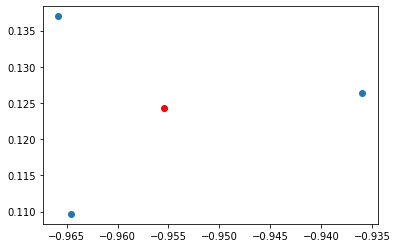

In [525]:
plt.scatter(triangles_coords[0,:,0], triangles_coords[0,:,1])
plt.scatter(centroids[0,0], centroids[0,1], color='red')

Calculamos la distancia desde el origen del rayo a cada centroide

In [526]:
dist_r_c = torch.norm(data.centroids - o.unsqueeze(0), dim=-1)

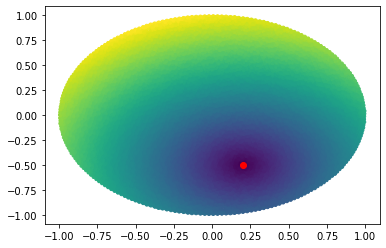

In [527]:
plt.scatter(centroids[:,0], centroids[:,1], c=dist_r_c, s=10)
plt.scatter(o[0], o[1], color='red')

Todo tiene sentido.

Calculamos la distancia rayo - centroides

In [528]:
distn = torch.norm(torch.cross(o - data.centroids, d.repeat(data.num_faces, 1), dim=1), dim=1) / torch.norm(d, dim=1)
distn = distn / distn.max()  # Normalize
features = torch.cat([o, d[0]]).unsqueeze(0)
data.x = features.repeat(data.num_nodes, 1)
data.y = distn
data.probs = ((1 - distn) > prob_reject).float()

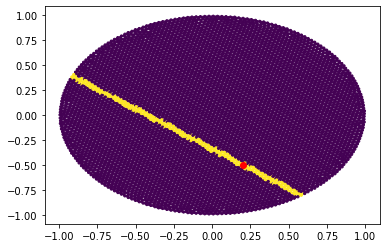

In [529]:
plt.scatter(centroids[:,0], centroids[:,1], c=data.probs, s=5)
plt.scatter(o[0], o[1], color='red')

#### 2. Sacar el triángulo en el que nos encontramos

In [530]:
o_triangle = dist_r_c.argmin().item()

In [531]:
triangles_coords[o_triangle,:,:2]

tensor([[ 0.1974, -0.4768],
        [ 0.1902, -0.5041],
        [ 0.2174, -0.4967]])

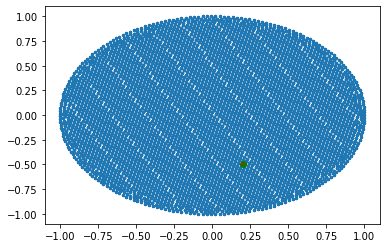

In [532]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

t1 = plt.Polygon(triangles_coords[o_triangle,:,:2], color='red', alpha=0.4)
plt.gca().add_patch(t1)
plt.scatter(o[0], o[1], color='green')

#### 3. Intersección de Rd con las aristas y determinación del siguiente triángulo

In [533]:
import numpy as np
from itertools import combinations

In [534]:
def line_ray_intersection_point(rayOrigin, rayDirection, point1, point2):   
    # Ray-Line Segment Intersection Test in 2D
    # http://bit.ly/1CoxdrG
    v1 = (rayOrigin - point1)[:-1]
    v2 = (point2 - point1)[:-1]
    v3 = np.array([-rayDirection[1], rayDirection[0]])
    t1 = np.cross(v2, v1) / np.dot(v2, v3)
    t2 = np.dot(v1, v3) / np.dot(v2, v3)
    if t1 >= 0.0 and t2 >= 0.0 and t2 <= 1.0:
        return True
    return False

In [535]:
idx_origin_triangle = triangles[o_triangle]
vertex_origin_triangle = triangles_coords[o_triangle]  # Only for plotting

In [536]:
for idx_p1, idx_p2 in combinations(idx_origin_triangle, 2):
    p1 = data.pos[idx_p1]
    p2 = data.pos[idx_p2]
    intersection = line_ray_intersection_point(centroids[o_triangle], d[0], p1, p2)
    if intersection:
        print(idx_p1, idx_p2)
        break

tensor(4071) tensor(4134)


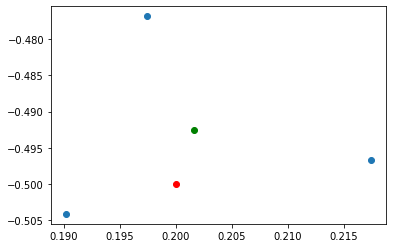

In [537]:
plt.scatter(vertex_origin_triangle[:,0], vertex_origin_triangle[:,1])
plt.scatter(o[0], o[1], color='red')
plt.scatter(centroids[o_triangle,0], centroids[o_triangle, 1], color='green')

Ya sabemos la arista, ahora hay que encontrar el siguiente triángulo. Esto habrá que cambiarlo para utilizar los vecinos.

In [538]:
next_triangle = torch.nonzero((triangles == idx_p1).any(1) * (triangles == idx_p2).any(1) * 
                              (triangles != idx_origin_triangle).any(1))[0,0]

In [539]:
triangles_visited = [o_triangle]
triangles_visited.append(next_triangle.item())

In [540]:
torch.norm(centroids[o_triangle] - centroids[next_triangle])

tensor(0.0163)

In [541]:
distances = [0]
distances.append(torch.norm(centroids[o_triangle] - centroids[next_triangle]).item())

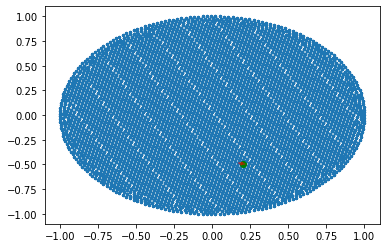

In [542]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

for t in triangles_visited:
    t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)
    
plt.scatter(o[0], o[1], color='green')

#### 4. Encontrar triángulos alrededor 

In [543]:
def calculate_neighbours(triangles):
    neighbours = {}
    combs = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
    for i_face, face in enumerate(triangles):
        neighbours_triangle = []
        for i1, i2, out in combs:
            v1 = face[i1]
            v2 = face[i2]
            vout = face[out]

            edge_neighbour = torch.nonzero((triangles == v1).any(1) * (triangles == v2).any(1) * (triangles != vout).all(1))[:,0]

            if len(edge_neighbour) == 0:
                edge_neighbour = -1
            elif len(edge_neighbour) > 1:
                raise ValueError('Something is wrong')
            else:
                edge_neighbour = edge_neighbour.item()
                
            neighbours_triangle.append(edge_neighbour)
        neighbours[i_face] = neighbours_triangle
    return neighbours

In [544]:
data.neighbours = calculate_neighbours(data.face.permute(1, 0))

In [545]:
data.neighbours

{0: [162, 72, 57],
 1: [4356, 90, 16],
 2: [34, 138, 1742],
 3: [2712, 110, 46],
 4: [8417, 13, 8590],
 5: [85, 21, 8917],
 6: [32, 92, 8603],
 7: [9, 8957, 8772],
 8: [1953, 19, 144],
 9: [290, 7006, 7],
 10: [67, 14, 3705],
 11: [97, -1, 50],
 12: [28, 3510, 74],
 13: [69, 4, 8479],
 14: [8983, 10, 133],
 15: [8779, 20, 8599],
 16: [9019, 1, 8879],
 17: [9170, 39, 38],
 18: [42, 168, 8502],
 19: [8731, 8, 195],
 20: [191, 15, 8704],
 21: [224, 7698, 5],
 22: [8457, 51, 27],
 23: [55, 5390, 135],
 24: [49, 178, 8536],
 25: [87, -1, 88],
 26: [145, 82, 8526],
 27: [22, 8552, 70],
 28: [4776, 122, 12],
 29: [8761, 243, 45],
 30: [5826, 53, 140],
 31: [64, 4501, 227],
 32: [125, 8307, 6],
 33: [73, 204, 8743],
 34: [8676, 2, 160],
 35: [8830, 9116, 37],
 36: [111, 8424, 96],
 37: [35, 8430, 8862],
 38: [17, 7470, 167],
 39: [17, 230, 7373],
 40: [100, 61, 9156],
 41: [44, 76, 8644],
 42: [127, 8008, 18],
 43: [6714, 98, 47],
 44: [130, 8626, 41],
 45: [29, 8905, 8711],
 46: [8664, 3, 882

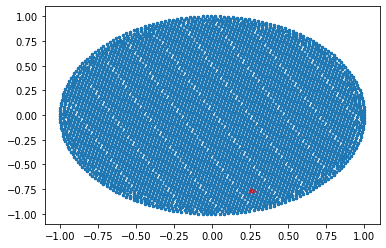

In [546]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

triangles_plot = data.neighbours[321] + [321]

for t in triangles_plot:
    t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)

Asignar a todos los triángulos una probabilidad según la media de sus vértices

In [547]:
data.probs_triangle = data.probs[triangles].mean(axis=1)

In [548]:
data.probs_triangle.shape

torch.Size([9233])

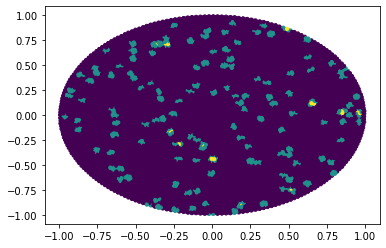

In [549]:
plt.scatter(centroids[:,0], centroids[:,1], c=data.probs_triangle, s=10)

#### 5. Bucle para terminar el proceso 

In [550]:
def evolve(data, visited):
    i=0
    while i < 200 and len(visited) < 100:
        last_triangle = visited[-2]
        current_triangle = visited[-1]

        current_neigh = data.neighbours[current_triangle]

        if -1 in current_neigh:
            break
            
        if len(triangles_visited) > 2:
            momentum_vector = centroids[current_triangle] - centroids[last_triangle]
        else:
            momentum_vector = d[0]
            
        y = centroids[current_neigh] - centroids[current_triangle]
        momentum = torch.einsum('s,bs->b', momentum_vector, y) / (momentum_vector.norm() * y.norm(dim=1))
        momentum = (momentum > 0).float()

        probs_neighbours = data.probs[current_neigh] * momentum
        if not probs_neighbours.any():
            print('No more neighbours found')
            visited.pop(-1)
        else:
            next_triangle = current_neigh[probs_neighbours.argmax().item()]
            visited.append(next_triangle)
            distances.append(torch.norm(centroids[next_triangle] - centroids[current_triangle]).item() + distances[-1])
        i += 1
    return visited

In [551]:
vis = evolve(data, triangles_visited.copy())

No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found
No more neighbours found


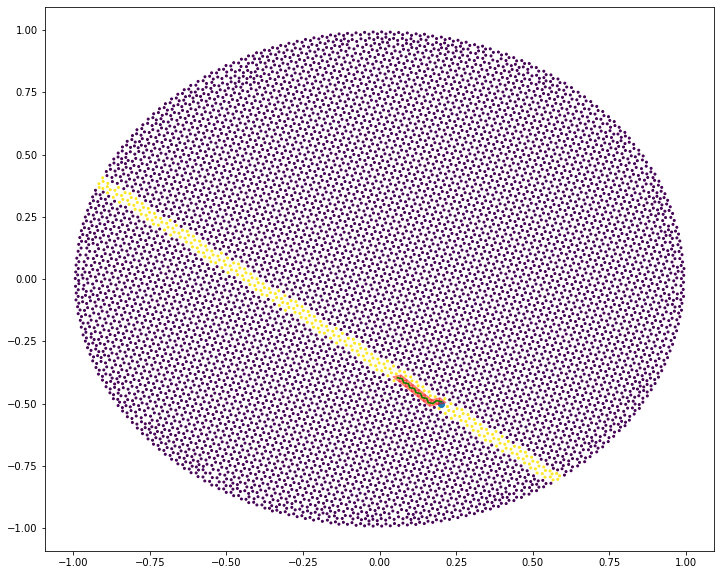

In [559]:
plt.figure(figsize=(12,10))
plt.scatter(centroids[:,0], centroids[:,1], c=data.probs, s=4)

triangles_plot = vis

for t in triangles_plot:
    t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)
    
plt.scatter(o[0], o[1])

plt.plot(data.centroids[triangles_plot][:,0], data.centroids[triangles_plot][:,1],color='green')
#plt.xlim([-0.25, 0.00])
#plt.ylim([-0.25, -0.5])

#### Tomar valores intermedios en una función a trozos 

Ejemplo

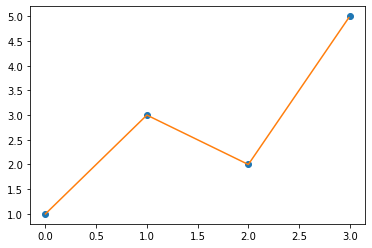

In [553]:
from scipy import interpolate

x = np.array([0, 1, 2, 3])
y = np.array([1, 3, 2, 5])

f = interpolate.interp1d(x, y)
xnew = np.arange(0, 3, 0.01)
ynew = f(xnew)
plt.plot(x, y, 'o', xnew, ynew, '-')

Aplicado a lo nuestro

El orden es MUY importante

In [554]:
t = data.centroids[vis]
t_sorted = t[t[:, 0].sort()[1]]

x = t_sorted[:,0]
y = t_sorted[:,1]

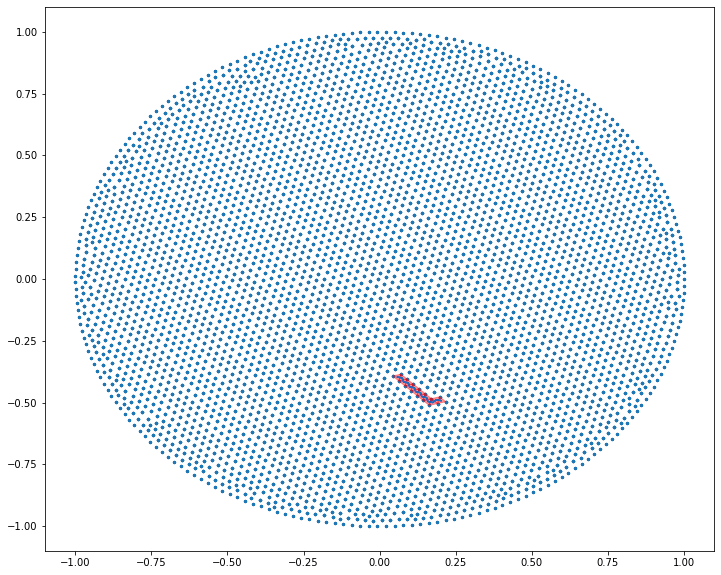

In [555]:
plt.figure(figsize=(12,10))
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

triangles_plot = vis

for triang in triangles_plot:
    t1 = plt.Polygon(triangles_coords[triang,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)

plt.plot(x, y, color='blue')
plt.plot(t[:,0],t[:,1])

In [556]:
f = interpolate.interp1d(x, y)

In [557]:
xnew = torch.arange(data.centroids[triangles_visited][:,0].min(), data.centroids[triangles_visited][:,0].max(), 0.001)
ynew = f(xnew)

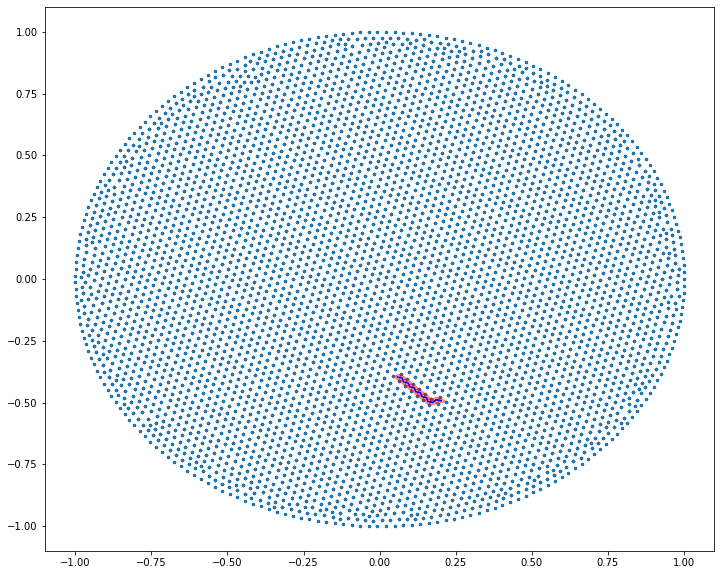

In [558]:
plt.figure(figsize=(12,10))
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

triangles_plot = vis

for triang in triangles_plot:
    t1 = plt.Polygon(triangles_coords[triang,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)

plt.plot(xnew, ynew, color='green')
plt.plot(x, y, color='blue')